<a href="https://colab.research.google.com/github/anuksan/cs50p/blob/main/Multimodal_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Agent with Haystack

* Can process images + PDFs 📄
* Access to tool: get weather ⛅️
* Uses [Haystack](https://haystack.deepset.ai/)
* See more examples in [Cookbook: Introduction to Multimodal Text Generation](https://haystack.deepset.ai/cookbook/multimodal_intro) and [Tutorial: Creating Vision+Text RAG Pipelines](https://haystack.deepset.ai/tutorials/46_multimodal_rag)


In [ ]:
%%bash

pip install -q haystack-ai pillow pypdf python-weather pypdfium2

In [ ]:
import gdown

url = "https://drive.google.com/drive/folders/1NxOIhPt2rvgTXgBdHwtVSOv3QIxwFQiu"

gdown.download_folder(url, quiet=True, output=".")

['./ahrefs_plans.pdf',
 './capybara.jpg',
 './datasciencedojo.jpeg',
 './map.png',
 './presentation.pdf',
 './survey.pdf']

In [ ]:
import os
from getpass import getpass
from google.colab import userdata

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## Working with Language Models (LLMs & VLMs)

Use a [Chat Generator](https://docs.haystack.deepset.ai/docs/generators) for different providers (OpenAI, Hugging Face, Amazon Bedrock, Anthropic, Google, Mistral, Ollama, vLLM...)

In [ ]:
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage

generator = OpenAIChatGenerator(model="gpt-4o-mini")
result = generator.run([ChatMessage.from_user("What's the capital of Germany?")])
result["replies"][0].text

'The capital of Germany is Berlin.'

## Preprocess Data into `ImageContent`

### Images

In [ ]:
from haystack.components.converters.image import ImageFileToImageContent

converter = ImageFileToImageContent(detail="low", size=(300, 300))
result = converter.run(sources=["capybara.jpg"])

In [ ]:
result

{'image_contents': [ImageContent(base64_image='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx...', mime_type='image/jpeg', detail='low', meta={'file_path': 'capybara.jpg'})]}

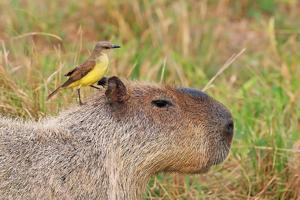

In [ ]:
result["image_contents"][0].show()

In [ ]:
content_parts = ["What is the name of this animal", result["image_contents"][0]]
result = generator.run([ChatMessage.from_user(content_parts=content_parts)])
result["replies"][0].text

"The animal in the image is a capybara. It's the largest rodent in the world and is often found in groups near water. The bird perched on its head is likely a type of bird that often interacts with capybaras, potentially providing a cleaning or symbiotic relationship."

### One-Pagers

In [ ]:
from haystack.components.converters.image import PDFToImageContent

pdf_converter = PDFToImageContent()
ahref_pdf = pdf_converter.run(sources=["/content/ahrefs_plans.pdf"])

In [ ]:
content_parts = ["Which subscription should I go for if I have more than 2000 keywords to be tracked", ahref_pdf["image_contents"][0]]
result = generator.run([ChatMessage.from_user(content_parts=content_parts)])

result["replies"][0].text

'If you have more than 2000 keywords to be tracked, you should consider the **Advanced** plan, as it allows for tracking up to 5,000 keywords. The **Enterprise** plan also supports tracking up to 10,000 keywords if you need even more capacity.'

### Slide Decks

In [ ]:
from haystack.components.converters.image import PDFToImageContent

pdf_converter = PDFToImageContent()
pdf_images = pdf_converter.run(sources=["/content/presentation.pdf"])


In [ ]:
content_parts = ["Based on the slide deck, what are the differences between agent and pipeline architectures?"] + pdf_images["image_contents"]
generator_response = generator.run([ChatMessage.from_user(content_parts=content_parts)])

print(generator_response["replies"][0].text)

The differences between agent and pipeline architectures can be summarized as follows:

### Agent Architecture:
- **Autonomy**: Agents operate autonomously and can pursue goals by interacting with their environment.
- **Complexity**: They are designed for complex, multi-step tasks that may require diverse actions.
- **Flexibility**: Tasks can utilize multiple tools/sources and the optimal path to achieve goals isn't predetermined.
- **Adaptability**: They think and act based on the current context, providing dynamic responses to changing situations.

### Pipeline Architecture:
- **Defined Flow**: Pipelines follow a predetermined sequence of steps for processing queries.
- **Predictability**: Best suited for tasks that involve predictable interaction patterns (e.g., question and answer).
- **Decomposability**: Tasks can be broken down into clear, distinct steps that don’t change dynamically.
- **Stability and Efficiency**: Emphasizes stability, robustness, and efficiency over complete a

In [ ]:
from haystack.components.converters.image import PDFToImageContent

pdf_converter = PDFToImageContent()
survey = pdf_converter.run(sources=["/content/survey.pdf"])

In [ ]:
content_parts = ["Do the planned actions seem targeted at the weakest areas?"] + survey["image_contents"]
generator_response = generator.run([ChatMessage.from_user(content_parts=content_parts)])

print(generator_response["replies"][0].text)

Based on the provided Pulse Check data and the next actions planned, it does seem that the actions are targeted at some of the weaker areas identified. Here’s a breakdown:

1. **Marketing (64%)**: This has the lowest participation rate. While it’s not directly mentioned in the next actions, the emphasis on "Manager Enablement" and "Goal Alignment" may indirectly support marketing teams through better leadership and alignment with goals.

2. **Leadership (3.77)**: This area appears to be targeted with initiatives such as the Leadership Development Program and Leadership Enablement Toolkit aimed at improving leadership capabilities.

3. **Diversity (3.55)**: The focus on DEI (Diversity, Equity, and Inclusion) and belonging suggests a direct approach to enhancing the scores in this area, emphasizing qualitative research and workshops.

4. **Workload (3.55)**: Although not directly addressed in the actions, improving manager capabilities and promoting professional growth may help alleviate

## Let's make our system smarter with Agent

In [ ]:
import asyncio
from typing import Annotated

from haystack.tools import tool
import python_weather

# only needed in Jupyter notebooks where there is an event loop running
import nest_asyncio
nest_asyncio.apply()

@tool
def get_weather(location: Annotated[str, "The location to get the weather for"]) -> dict:
    """A function to get the weather for a given location"""
    async def _fetch_weather():
        async with python_weather.Client(unit=python_weather.METRIC) as client:
            weather = await client.get(location)
            return {
                "description": weather.description,
                "temperature": weather.temperature,
                "humidity": weather.humidity,
                "precipitation": weather.precipitation,
                "wind_speed": weather.wind_speed,
                "wind_direction": weather.wind_direction
            }

    return asyncio.run(_fetch_weather())

In [ ]:
get_weather.name

'get_weather'

In [ ]:
get_weather.description

'A function to get the weather for a given location'

In [ ]:
get_weather.parameters

{'properties': {'location': {'type': 'string',
   'description': 'The location to get the weather for'}},
 'required': ['location'],
 'type': 'object'}

### Tool Calling Agent

In [ ]:
from haystack.components.agents import Agent
from haystack.components.generators.chat import OpenAIChatGenerator

generator = OpenAIChatGenerator(model="gpt-4o-mini")
agent = Agent(
    chat_generator=generator,
    tools=[get_weather],
    system_prompt="You're a helpful agent"
)

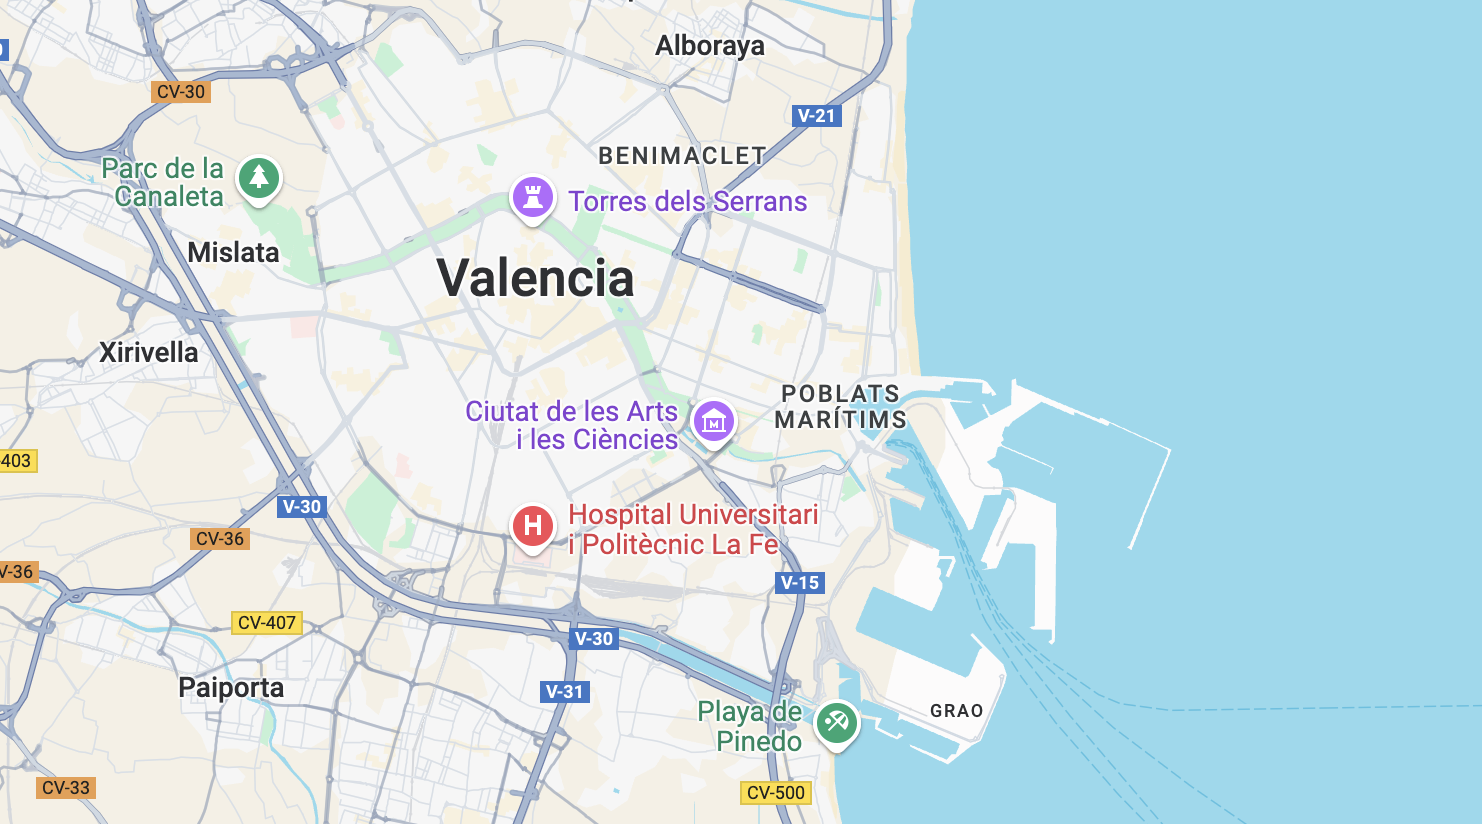

In [ ]:
from haystack.dataclasses import ImageContent

map_image = ImageContent.from_file_path("map.png")
map_image.show()

In [ ]:
content_parts = ["How are you today?"]
agent_response = agent.run([ChatMessage.from_user(content_parts=content_parts)])

print(agent_response["last_message"].text)

I'm just a program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?


In [ ]:
content_parts = ["What is the weather in the area of the map?", map_image]
agent_response = agent.run([ChatMessage.from_user(content_parts=content_parts)])

print(agent_response["last_message"].text)

The weather in Valencia, Spain is currently sunny with a temperature of 30°C. The humidity is at 55%, there is no precipitation, and the wind is blowing from the east-southeast at a speed of 17 km/h.


### Observability: Add Streaming

In [ ]:
from haystack.components.generators.utils import print_streaming_chunk

content_parts = ["What is the weather in the area of the map?", map_image]
agent_response = agent.run([ChatMessage.from_user(content_parts=content_parts)], streaming_callback=print_streaming_chunk)

[TOOL CALL]
Tool: get_weather 
Arguments: {"location":"Valencia, Spain"}

[TOOL RESULT]
{'description': 'Sunny', 'temperature': 30, 'humidity': 55, 'precipitation': 0.0, 'wind_speed': 17, 'wind_direction': WindDirection.EAST_SOUTHEAST}

[ASSISTANT]
The current weather in Valencia, Spain is sunny, with a temperature of 30°C. The humidity level is at 55%, and there is no precipitation. The wind is blowing from the east-southeast at a speed of 17 km/h.



### Use a different VLM
Let's try `Gemini-2.5-Pro`

In [ ]:
!pip install -q -U google-genai-haystack

In [ ]:
import os
from getpass import getpass
from google.colab import userdata

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [ ]:
from haystack_integrations.components.generators.google_genai import GoogleGenAIChatGenerator

google_generator = GoogleGenAIChatGenerator(
    model="gemini-2.5-pro"
)

In [ ]:
from haystack.components.converters.image import ImageFileToImageContent

converter = ImageFileToImageContent(detail="low", size=(300, 300))
result = converter.run(sources=["capybara.jpg"])

content_parts = ["What is the name of this animal", result["image_contents"][0]]
chat_generator_result = google_generator.run([ChatMessage.from_user(content_parts=content_parts)])
chat_generator_result["replies"][0].text

"Based on the image, there are two animals present.\n\nThe large, furry animal is a **Capybara** (*Hydrochoerus hydrochaeris*). It is the world's largest rodent and is known for its calm and social nature, which is why other animals are often seen resting on or near it.\n\nThe small bird perched on its back is a **Cattle Tyrant** (*Machetornis rixosa*). These birds often perch on large mammals to catch insects that are stirred up as the larger animal moves through the grass."

In [ ]:
from haystack.components.agents import Agent

google_agent = Agent(
    chat_generator=google_generator,
    tools=[get_weather],
    system_prompt="You're a helpful agent"
)

In [ ]:
from haystack.components.generators.utils import print_streaming_chunk

content_parts = ["What is the weather in the area of the map?", map_image]
agent_response = google_agent.run([ChatMessage.from_user(content_parts=content_parts)], streaming_callback=print_streaming_chunk)

[TOOL CALL]
Tool: get_weather 
Arguments: {"location": "Valencia"}

[TOOL RESULT]
{'description': 'Sunny', 'temperature': 30, 'humidity': 55, 'precipitation': 0.0, 'wind_speed': 17, 'wind_direction': WindDirection.EAST_SOUTHEAST}

[ASSISTANT]

The weather in Valencia is sunny with a temperature of 30 degrees Celsius. The humidity is 55%, there is no precipitation, and the wind is blowing from the east-southeast at 17 km/h.

